In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN

In [2]:
# 加载数据
signal_data_path = "MODEL2/bin1000_signal.csv"
meta_data_path = "MODEL2/bin1000_meta.csv"

# 读取CSV文件
signal_data = pd.read_csv(signal_data_path, index_col=0)
meta_data = pd.read_csv(meta_data_path)

# 确保meta_data中有需要的列
required_columns = ["ID", "PEAK"]
if not all(col in meta_data.columns for col in required_columns):
    raise ValueError("meta_data文件中缺少必要的列: ID, PEAK")

# 将meta_data的ID列设置为索引
meta_data.set_index("ID", inplace=True)

# 确保行名和ID列一致，如果不一致则对齐
if not (signal_data.index == meta_data.index).all():
    common_ids = signal_data.index.intersection(meta_data.index)
    signal_data = signal_data.loc[common_ids]
    meta_data = meta_data.loc[common_ids]

# 将PEAK列转换为数字编码
label_mapping = {"Decreasing": 0, "Increasing": 1, "Overlap": 2, "Plateau": 3, "Simple": 4}
meta_data["PEAK"] = meta_data["PEAK"].map(label_mapping)

# 确保映射成功
if meta_data["PEAK"].isnull().any():
    raise ValueError("PEAK列中存在无法映射的值，请检查label_mapping或输入数据")

# 添加Final_Label列，和PEAK列保持一致
meta_data["Final_Label"] = meta_data["PEAK"]
meta_data["Final_Label"].value_counts()

Final_Label
4    367
2     43
0     36
3     30
1     11
Name: count, dtype: int64

In [3]:
# 加载预测数据
signal_data_path_pre = "../bin1000_signal.csv"
meta_data_path_pre = "../bin1000_meta.csv"

# 读取CSV文件
signal_data_pre = pd.read_csv(signal_data_path_pre, index_col=0)
meta_data_pre = pd.read_csv(meta_data_path_pre)

# 确保meta_data中有需要的列
required_columns = ["ID", "PEAK1", "PEAK2", "PEAK3"]
if not all(col in meta_data_pre.columns for col in required_columns):
    raise ValueError("meta_data文件中缺少必要的列: ID, PEAK1, PEAK2, PEAK3")

# 将meta_data的ID列设置为索引
meta_data_pre.set_index("ID", inplace=True)

# 定义函数以计算最终标注
def resolve_label(row):
    labels = [row["PEAK1"], row["PEAK2"], row["PEAK3"]]
    label_counts = pd.Series(labels).value_counts()
    
    # 至少两人一致的标注
    for label, count in label_counts.items():
        if count >= 2:
            return label

    # 如果三人标注均不一致，默认取PEAK1
    return row["PEAK1"]

# 应用函数处理标注
meta_data_pre["Final_Label"] = meta_data_pre.apply(resolve_label, axis=1)

# 筛选 PEAK1、PEAK2、PEAK3 一致的图片
#signal_data_pre = signal_data_pre[(meta_data_pre['PEAK1'] == meta_data_pre['PEAK2']) & (meta_data_pre['PEAK2'] == meta_data_pre['PEAK3'])]
#meta_data_pre = meta_data_pre[(meta_data_pre['PEAK1'] == meta_data_pre['PEAK2']) & (meta_data_pre['PEAK2'] == meta_data_pre['PEAK3'])]

# 确保行名和ID列一致，如果不一致则对齐
if not (signal_data_pre.index == meta_data_pre.index).all():
    common_ids = signal_data_pre.index.intersection(meta_data_pre.index)
    signal_data_pre = signal_data_pre.loc[common_ids]
    meta_data_pre = meta_data_pre.loc[common_ids]

# 将Final_Label转换为数字编码
label_mapping = {"Decreasing": 0, "Increasing": 1, "Overlap": 2, "Plateau": 3, "Simple": 4}
meta_data_pre["Final_Label"] = meta_data_pre["PEAK1"].map(label_mapping)
meta_data_pre["Final_Label"].value_counts()

Final_Label
4    1128
2      92
3      84
0      47
1       8
Name: count, dtype: int64

In [4]:
# 1. 获取 meta_data_pre 和 signal_data_pre 的一半数据
half_meta_data_pre = meta_data_pre.iloc[:len(meta_data_pre) // 2]
half_signal_data_pre = signal_data_pre.iloc[:len(signal_data_pre) // 2]

# 2. 合并 meta_data 和 meta_data_pre 的一半数据
meta_data_combined = pd.concat([meta_data, half_meta_data_pre], axis=0, ignore_index=True)

# 3. 合并 signal_data 和 signal_data_pre 的一半数据
signal_data_combined = pd.concat([signal_data, half_signal_data_pre], axis=0, ignore_index=True)

# 打印前几行结果检查
meta_data_combined["Final_Label"].value_counts()

Final_Label
4    932
2     92
3     65
0     61
1     16
Name: count, dtype: int64

In [5]:
# 合并数据，检查索引唯一性并重置
balanced_data = pd.concat([signal_data_combined, meta_data_combined["Final_Label"]], axis=1)
balanced_data = balanced_data.reset_index(drop=True)  # 确保索引唯一

In [6]:
# 提取特征和标签
features = balanced_data.iloc[:, :-1]  # 特征
labels = balanced_data.iloc[:, -1]    # 标签
print(features.shape)
print(labels.shape)

# 特征标准化
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)  # 标准化后是 NumPy 数组
features = pd.DataFrame(features_scaled, columns=features.columns)  # 转换回 DataFrame

# 保存标准化器
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

(1166, 1000)
(1166,)


In [7]:
# 使用 SMOTE 和 ADASYN 进行样本平衡（仅使用 train 数据）
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)
borderline = BorderlineSMOTE(random_state=42)
smoteenn = SMOTEENN(random_state=42)

features_smote, labels_smote = smote.fit_resample(features, labels)
features_adasyn, labels_adasyn = adasyn.fit_resample(features, labels)
features_borderline, labels_borderline = borderline.fit_resample(features, labels)
features_smoteenn, labels_smoteenn = smoteenn.fit_resample(features, labels)

# 转换为 DataFrame（如果需要后续操作与原代码一致）
features_smote = pd.DataFrame(features_smote, columns=features.columns)
labels_smote = pd.Series(labels_smote, name="Final_Label")

features_adasyn = pd.DataFrame(features_adasyn, columns=features.columns)
labels_adasyn = pd.Series(labels_adasyn, name="Final_Label")

features_borderline = pd.DataFrame(features_borderline, columns=features.columns)
labels_borderline = pd.Series(labels_borderline, name="Final_Label")

features_smoteenn = pd.DataFrame(features_smoteenn, columns=features.columns)
labels_smoteenn = pd.Series(labels_smoteenn, name="Final_Label")

# 检查每类样本的数量
print("使用 SMOTE 后每类样本数量:")
print(labels_smote.value_counts())
print(labels_adasyn.value_counts())
print(labels_borderline.value_counts())
print(labels_smoteenn.value_counts())

# 合并 SMOTE 和 ADASYN 生成的特征和标签
features_combined = pd.concat([features_smote], axis=0)
labels_combined = pd.concat([labels_smote], axis=0)

# 打乱数据
features_combined, labels_combined = shuffle(features_combined, labels_combined, random_state=42)

# 检查合并后的每类样本数量
print("合并后的每类样本数量:")
print(labels_combined.value_counts())

/home/yhw/software/anaconda3/envs/pytorch.p39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/yhw/software/anaconda3/envs/pytorch.p39/lib/python3.9/site-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/home/yhw/software/anaconda3/envs/pytorch.p39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseE

使用 SMOTE 后每类样本数量:
Final_Label
4    932
0    932
1    932
2    932
3    932
Name: count, dtype: int64
Final_Label
3    935
4    932
1    930
0    926
2    911
Name: count, dtype: int64
Final_Label
4    932
0    932
1    932
2    932
3    932
Name: count, dtype: int64
Final_Label
1    930
0    928
3    923
2    920
4    771
Name: count, dtype: int64
合并后的每类样本数量:
Final_Label
0    932
3    932
2    932
1    932
4    932
Name: count, dtype: int64


In [8]:
# 首先将数据集划分为 90%（训练+验证集）和 10%（测试集）
train_val_features, test_features, train_val_labels, test_labels = train_test_split(
    features_combined, labels_combined, 
    test_size=0.1,  # 测试集占比
    random_state=42, 
    stratify=labels_combined  # 确保类别分布均衡
)

# 然后在训练+验证集中划分 70%（训练集）和 20%（验证集）
train_features, val_features, train_labels, val_labels = train_test_split(
    train_val_features, train_val_labels, 
    test_size=2/9,  # 验证集占训练+验证集的比例
    random_state=42, 
    stratify=train_val_labels  # 确保类别分布均衡
)

In [9]:
# 自定义Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(signals.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

# 构建数据集和数据加载器
train_dataset = TimeSeriesDataset(train_features, train_labels)
val_dataset = TimeSeriesDataset(val_features, val_labels)
test_dataset = TimeSeriesDataset(test_features, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 可调整batch_size
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# 定义 CNN 模型
class CNNModel1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNNModel1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = None  # 占位符
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        
        # 动态计算 Flatten 大小
        with torch.no_grad():
            test_tensor = torch.zeros(1, 1, input_dim)  # 创建虚拟输入
            test_tensor = self.pool(F.relu(self.conv1(test_tensor)))
            test_tensor = self.pool(F.relu(self.conv2(test_tensor)))
            self.flatten_dim = test_tensor.view(1, -1).size(1)
        
        self.fc1 = nn.Linear(self.flatten_dim, 64)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器
input_dim = features.shape[1]
num_classes = len(label_mapping)
model = CNNModel1D(input_dim = input_dim, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [11]:
# 创建 TensorBoard SummaryWriter 实例
writer = SummaryWriter(log_dir="runs/CNNModel1D")  # 你可以自定义日志路径

# 训练
epochs = 100
patience = 5  # 早停的容忍次数
best_val_loss = float('inf')  # 初始化验证集最优损失
counter = 0  # 计数器，记录验证集损失未改善的次数

for epoch in range(epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct_train = 0  # 记录正确预测的数量
    total_train = 0    # 记录总样本数

    for signals, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # 计算训练准确率
        _, predicted = torch.max(outputs, 1)  # 得到最大概率对应的类别
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()  # 统计正确预测的数量

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train  # 准确率百分比

    # 验证阶段
    model.eval()
    correct_val = 0  # 记录正确预测的数量
    total_val = 0    # 记录总样本数
    val_loss = 0.0

    with torch.no_grad():
        for signals, labels in val_loader:
            outputs = model(signals)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 计算验证准确率
            _, predicted = torch.max(outputs, 1)  # 得到最大概率对应的类别
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()  # 统计正确预测的数量

    val_loss /= len(val_loader)  # 平均验证损失
    val_accuracy = 100 * correct_val / total_val  # 准确率百分比

    # 打印每个 epoch 的训练和验证损失及准确率
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # 记录训练和验证损失到 TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    # 早停判断
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()  # 保存最佳模型
    else:
        counter += 1
        print(f"Early Stopping Counter: {counter}/{patience}")

    if counter >= patience:
        print("Early stopping triggered!")
        break

# 加载最优模型状态
model.load_state_dict(best_model_state)
torch.save(best_model_state, "best_model.pth")

# 关闭 TensorBoard writer
writer.close()

Epoch 1/100, Train Loss: 0.6766, Train Accuracy: 75.44%, Val Loss: 0.3987, Val Accuracy: 84.98%
Epoch 2/100, Train Loss: 0.4990, Train Accuracy: 83.11%, Val Loss: 0.3178, Val Accuracy: 89.38%
Epoch 3/100, Train Loss: 0.4462, Train Accuracy: 84.55%, Val Loss: 0.2962, Val Accuracy: 90.02%
Epoch 4/100, Train Loss: 0.4341, Train Accuracy: 84.55%, Val Loss: 0.2732, Val Accuracy: 90.67%
Epoch 5/100, Train Loss: 0.4157, Train Accuracy: 85.44%, Val Loss: 0.2627, Val Accuracy: 91.74%
Epoch 6/100, Train Loss: 0.3728, Train Accuracy: 86.54%, Val Loss: 0.2317, Val Accuracy: 92.92%
Epoch 7/100, Train Loss: 0.3694, Train Accuracy: 86.94%, Val Loss: 0.2283, Val Accuracy: 92.60%
Epoch 8/100, Train Loss: 0.3680, Train Accuracy: 87.65%, Val Loss: 0.2492, Val Accuracy: 91.63%
Early Stopping Counter: 1/5
Epoch 9/100, Train Loss: 0.3412, Train Accuracy: 87.80%, Val Loss: 0.2036, Val Accuracy: 93.03%
Epoch 10/100, Train Loss: 0.3319, Train Accuracy: 88.63%, Val Loss: 0.2117, Val Accuracy: 93.03%
Early Stopp

In [12]:
# 测试
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for signals, labels in test_loader:
        outputs = model(signals)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

Classification Report:
              precision    recall  f1-score   support

  Decreasing       0.96      0.92      0.94        93
  Increasing       1.00      1.00      1.00        93
     Overlap       0.93      0.90      0.92        93
     Plateau       0.97      0.96      0.96        94
      Simple       0.87      0.94      0.90        93

    accuracy                           0.94       466
   macro avg       0.95      0.94      0.94       466
weighted avg       0.95      0.94      0.94       466



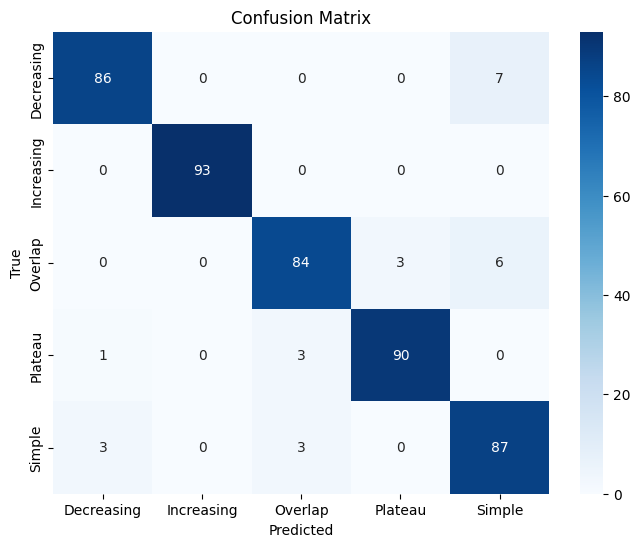

In [13]:
# 分类报告和混淆矩阵
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix_train.pdf')  # 保存为 PDF 文件
plt.show()

/tmp/ipykernel_72453/1812501182.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_prob = torch.softmax(torch.tensor(model(torch.tensor(test_features.values, dtype=torch.float32))), dim=1).numpy()


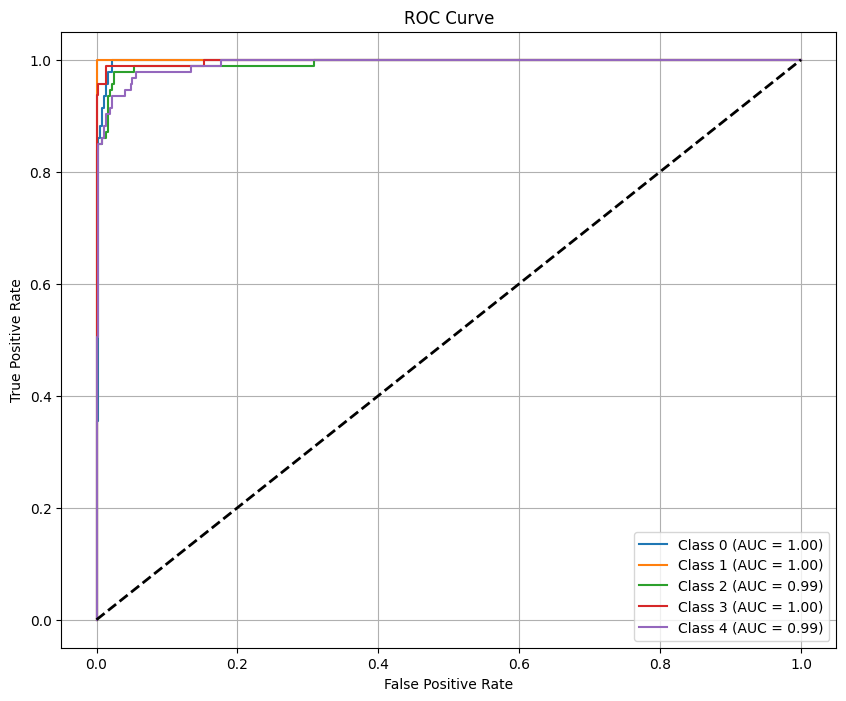

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 如果是多分类任务，首先将标签二值化
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])  # 替换为实际类别
n_classes = y_true_bin.shape[1]

# 计算每个类别的 ROC 曲线和 AUC
y_pred_prob = torch.softmax(torch.tensor(model(torch.tensor(test_features.values, dtype=torch.float32))), dim=1).numpy()
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 基线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig('roc_curve_train.pdf')  # 保存为 PDF 文件
plt.show()

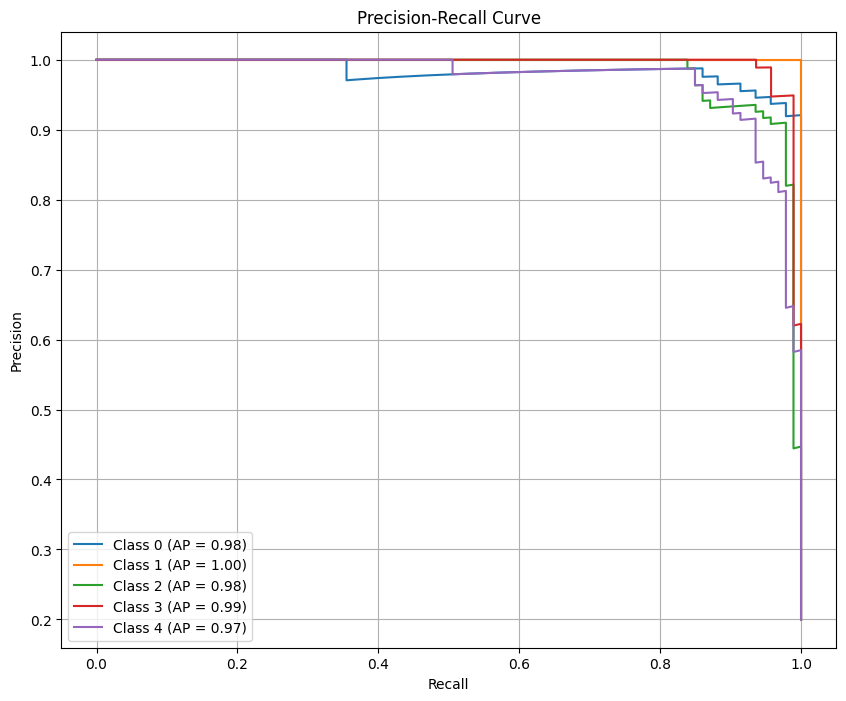

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 计算每个类别的 PR 曲线和平均精确度
precision = {}
recall = {}
average_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])

# 绘制 PR 曲线
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {average_precision[i]:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.savefig('pr_curve_train.pdf')  # 保存为 PDF 文件
plt.show()

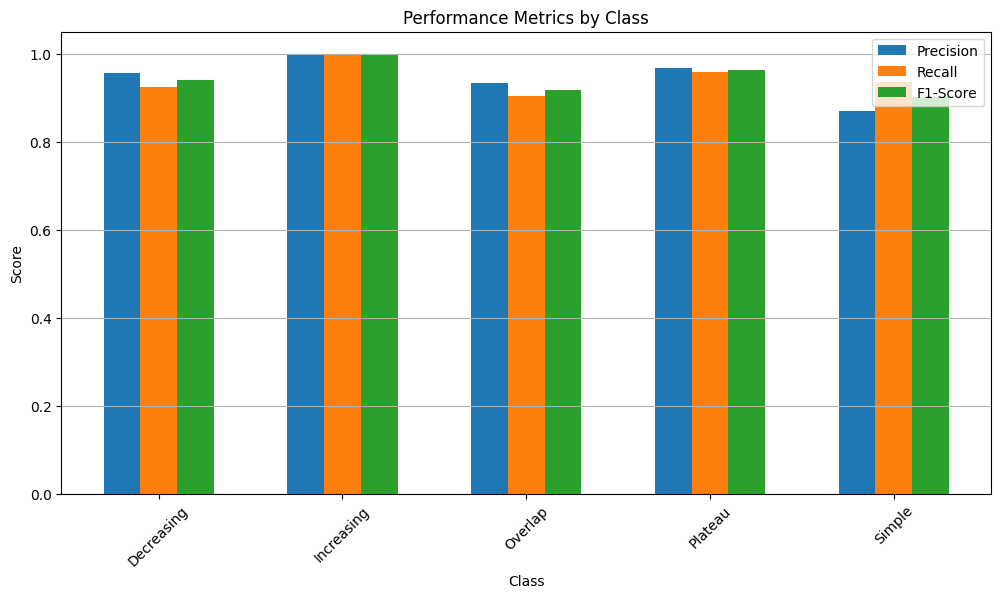

In [16]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# 计算每个类别的性能指标
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred)

# 绘制条形图
x = np.arange(len(label_mapping))  # 类别索引
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Performance Metrics by Class')
plt.xticks(x, label_mapping.keys(), rotation=45)
plt.legend()
plt.grid(axis='y')
plt.savefig('metrics_barplot_train.pdf')  # 保存为 PDF 文件
plt.show()

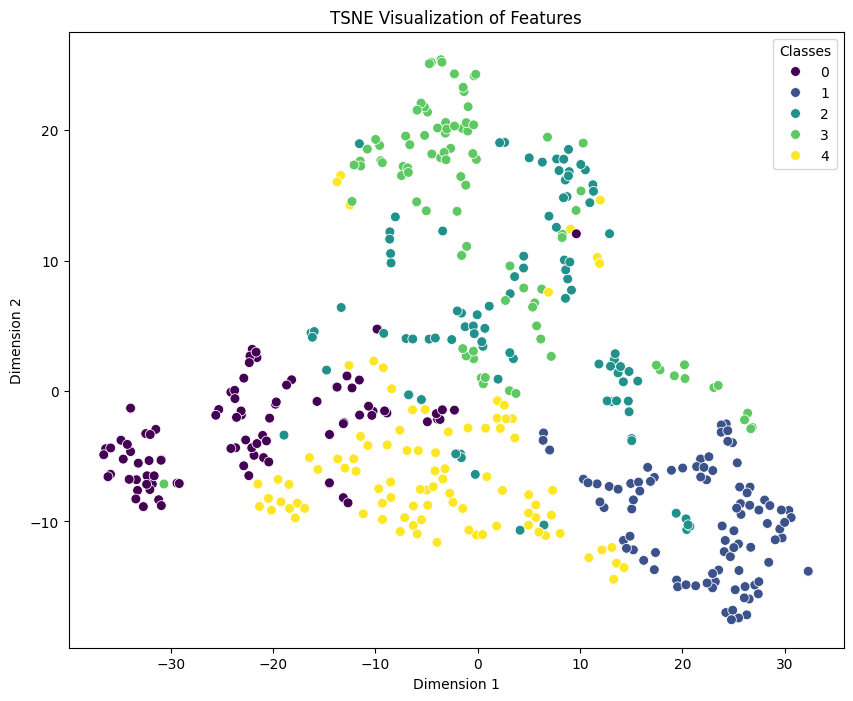

In [17]:
from sklearn.manifold import TSNE
import seaborn as sns

# 提取测试集特征并降维
features_embedded = TSNE(n_components=2, random_state=42).fit_transform(test_features.values)

# 绘制降维后的分布
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_embedded[:, 0], y=features_embedded[:, 1], hue=y_true, palette='viridis', s=50)
plt.title('TSNE Visualization of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Classes')
plt.show()

In [18]:
# 1. 保存原始数据的索引顺序
original_index = meta_data_pre.index

# 2. 加载训练时保存的标准化器
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# 3. 标准化信号数据
features_scaled_pre = scaler.transform(signal_data_pre)
features_pre = pd.DataFrame(features_scaled_pre, columns=signal_data_pre.columns)

# 4. 定义预测数据集
class PredictDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

predict_dataset = PredictDataset(features_pre)

# 5. 使用 DataLoader 加载预测数据
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

# 6. 加载最佳模型
input_dim = features_pre.shape[1]
num_classes = len(label_mapping)

model = CNNModel1D(input_dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# 7. 模型预测
device = 'cpu'
predicted_labels = []
with torch.no_grad():
    for signals in predict_loader:
        # 修复维度问题
        if signals.dim() == 4:  # 如果是 4D 输入
            signals = signals.squeeze(1)  # 移除多余的维度
        signals = signals.to(device)  # 移动到 GPU（如果可用）
        
        outputs = model(signals)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.numpy())

# 8. 将预测标签添加到 meta_data_pre
meta_data_pre["Predicted_Label"] = predicted_labels

# 9. 将 Predicted_Label 映射回类型标签
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
meta_data_pre["Predicted_Peak"] = meta_data_pre["Predicted_Label"].map(reverse_label_mapping)

# 10. 恢复原始索引顺序
meta_data_pre = meta_data_pre.loc[original_index]

# 11. 打印结果
print(meta_data_pre.head())

/tmp/ipykernel_72453/1149808912.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


     Unnamed: 0   PEAK1   PEAK2       PEAK3  Final_Label  Predicted_Label  \
ID                                                                          
A1            1  Simple  Simple     Plateau            4                4   
A10           2  Simple  Simple      Simple            4                4   
A11           3  Simple  Simple      Simple            4                3   
A2            4  Simple  Simple      Simple            4                4   
A3            5  Simple  Simple  Increasing            4                4   

    Predicted_Peak  
ID                  
A1          Simple  
A10         Simple  
A11        Plateau  
A2          Simple  
A3          Simple  


In [19]:
meta_data_pre["Predicted_Peak"].value_counts()

Predicted_Peak
Simple        1050
Overlap        110
Plateau         93
Decreasing      88
Increasing      18
Name: count, dtype: int64

In [20]:
meta_data_pre["PEAK1"].value_counts()

PEAK1
Simple        1128
Overlap         92
Plateau         84
Decreasing      47
Increasing       8
Name: count, dtype: int64

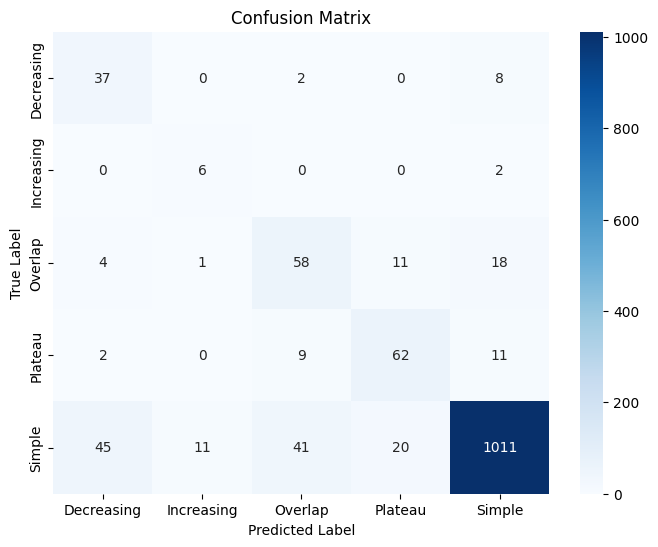

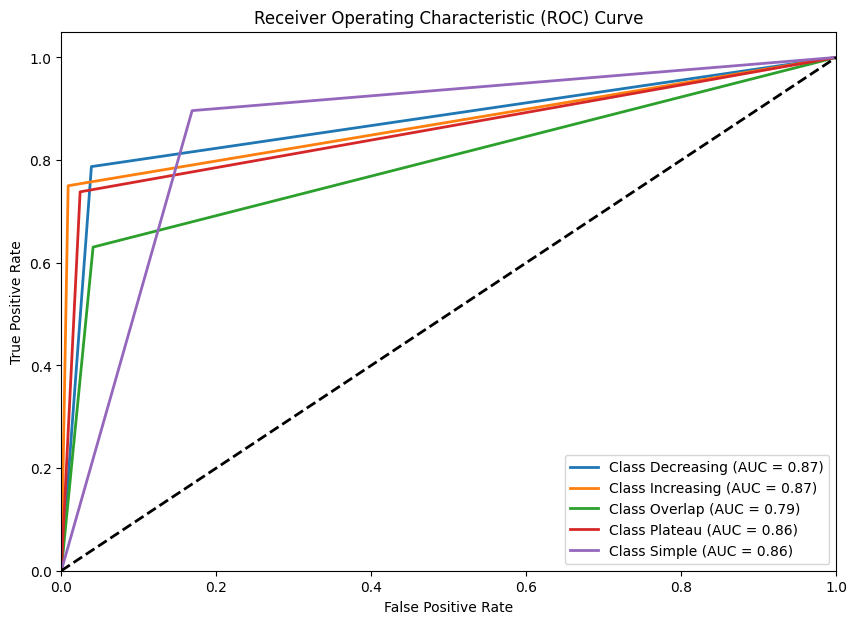

Confusion Matrix and ROC Curve saved as PDFs.


In [21]:
# 将 PEAK1 和 Predicted_Peak 转换为数字
meta_data_pre['PEAK1_numeric'] = meta_data_pre['PEAK1'].map(label_mapping)
meta_data_pre['Predicted_Peak_numeric'] = meta_data_pre['Predicted_Peak'].map(label_mapping)

# 现在可以使用这两个新的列来绘制 ROC 曲线和混淆矩阵
y_true = meta_data_pre['PEAK1_numeric'].values  # 真实标签
y_pred = meta_data_pre['Predicted_Peak_numeric'].values  # 预测标签

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 保存混淆矩阵热图为 PDF
plt.savefig("confusion_matrix_predicted.pdf", format="pdf")
plt.show()
plt.close()  # 关闭当前图表，避免与下一个图形重叠

# 计算 ROC 曲线
# 将标签转化为二进制格式（对于多类分类问题）
y_true_bin = label_binarize(y_true, classes=list(label_mapping.values()))
y_pred_bin = label_binarize(y_pred, classes=list(label_mapping.values()))

# 计算每个类的 ROC 曲线
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_mapping)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 7))
for i in range(len(label_mapping)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {list(label_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 绘制对角线（随机预测线）
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 保存 ROC 曲线为 PDF
plt.savefig("roc_curve_predicted.pdf", format="pdf")
plt.show()
plt.close()  # 关闭当前图表

print("Confusion Matrix and ROC Curve saved as PDFs.")

In [22]:
# 保存更新后的元数据
meta_data_pre.to_csv("updated_metadata.csv", index=False)
print("预测结果已成功添加并保存到 updated_metadata.csv")

预测结果已成功添加并保存到 updated_metadata.csv


In [38]:
# 加载预测数据 (小鼠)
signal_data_path_pre = "/home/yhw/bioinfo/project-zyf/Release/mouse release/mouse release/bin1000_signal.csv"
meta_data_path_pre = "/home/yhw/bioinfo/project-zyf/Release/mouse release/mouse release/bin1000_meta.csv"

# 读取CSV文件
signal_data_pre = pd.read_csv(signal_data_path_pre, index_col=0)
meta_data_pre = pd.read_csv(meta_data_path_pre)

# 将meta_data的ID列设置为索引
meta_data_pre.set_index("ID", inplace=True)

# 确保行名和ID列一致，如果不一致则对齐
if not (signal_data_pre.index == meta_data_pre.index).all():
    common_ids = signal_data_pre.index.intersection(meta_data_pre.index)
    signal_data_pre = signal_data_pre.loc[common_ids]
    meta_data_pre = meta_data_pre.loc[common_ids]

meta_data_pre["PEAK"].value_counts()

PEAK
/    1442
Name: count, dtype: int64

In [39]:
# 1. 保存原始数据的索引顺序
original_index = meta_data_pre.index

# 2. 加载训练时保存的标准化器
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# 3. 标准化信号数据
features_scaled_pre = scaler.transform(signal_data_pre)
features_pre = pd.DataFrame(features_scaled_pre, columns=signal_data_pre.columns)

# 4. 定义预测数据集
class PredictDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

predict_dataset = PredictDataset(features_pre)

# 5. 使用 DataLoader 加载预测数据
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

# 6. 加载最佳模型
input_dim = features_pre.shape[1]
num_classes = len(label_mapping)

model = CNNModel1D(input_dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# 7. 模型预测
device = 'cpu'
predicted_labels = []
with torch.no_grad():
    for signals in predict_loader:
        # 修复维度问题
        if signals.dim() == 4:  # 如果是 4D 输入
            signals = signals.squeeze(1)  # 移除多余的维度
        signals = signals.to(device)  # 移动到 GPU（如果可用）
        
        outputs = model(signals)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.numpy())

# 8. 将预测标签添加到 meta_data_pre
meta_data_pre["Predicted_Label"] = predicted_labels

# 9. 将 Predicted_Label 映射回类型标签
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
meta_data_pre["Predicted_Peak"] = meta_data_pre["Predicted_Label"].map(reverse_label_mapping)

# 10. 恢复原始索引顺序
meta_data_pre = meta_data_pre.loc[original_index]

# 11. 打印结果
print(meta_data_pre.head())

/tmp/ipykernel_72453/1149808912.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


     Unnamed: 0 PEAK  Predicted_Label Predicted_Peak
ID                                                  
A1            1    /                3        Plateau
A10           2    /                4         Simple
A11           3    /                4         Simple
A2            4    /                2        Overlap
A3            5    /                4         Simple


In [40]:
# 保存更新后的元数据
meta_data_pre.to_csv("mouse_release_metadata.csv", index=True)
print("预测结果已成功添加并保存到 mouse_release_metadata.csv")

预测结果已成功添加并保存到 mouse_release_metadata.csv


In [34]:
# 加载预测数据 (mns)
signal_data_path_pre = "/home/yhw/bioinfo/project-zyf/Release/mns/mns/bin1000_signal.csv"
meta_data_path_pre = "/home/yhw/bioinfo/project-zyf/Release/mns/mns/bin1000_meta.csv"

# 读取CSV文件
signal_data_pre = pd.read_csv(signal_data_path_pre, index_col=0)
meta_data_pre = pd.read_csv(meta_data_path_pre)

# 将meta_data的ID列设置为索引
meta_data_pre.set_index("ID", inplace=True)

# 确保行名和ID列一致，如果不一致则对齐
if not (signal_data_pre.index == meta_data_pre.index).all():
    common_ids = signal_data_pre.index.intersection(meta_data_pre.index)
    signal_data_pre = signal_data_pre.loc[common_ids]
    meta_data_pre = meta_data_pre.loc[common_ids]

meta_data_pre["PEAK"].value_counts()

PEAK
/    87
Name: count, dtype: int64

In [35]:
# 1. 保存原始数据的索引顺序
original_index = meta_data_pre.index

# 2. 加载训练时保存的标准化器
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# 3. 标准化信号数据
features_scaled_pre = scaler.transform(signal_data_pre)
features_pre = pd.DataFrame(features_scaled_pre, columns=signal_data_pre.columns)

# 4. 定义预测数据集
class PredictDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

predict_dataset = PredictDataset(features_pre)

# 5. 使用 DataLoader 加载预测数据
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

# 6. 加载最佳模型
input_dim = features_pre.shape[1]
num_classes = len(label_mapping)

model = CNNModel1D(input_dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# 7. 模型预测
device = 'cpu'
predicted_labels = []
with torch.no_grad():
    for signals in predict_loader:
        # 修复维度问题
        if signals.dim() == 4:  # 如果是 4D 输入
            signals = signals.squeeze(1)  # 移除多余的维度
        signals = signals.to(device)  # 移动到 GPU（如果可用）
        
        outputs = model(signals)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.numpy())

# 8. 将预测标签添加到 meta_data_pre
meta_data_pre["Predicted_Label"] = predicted_labels

# 9. 将 Predicted_Label 映射回类型标签
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
meta_data_pre["Predicted_Peak"] = meta_data_pre["Predicted_Label"].map(reverse_label_mapping)

# 10. 恢复原始索引顺序
meta_data_pre = meta_data_pre.loc[original_index]

# 11. 打印结果
print(meta_data_pre.head())

    Unnamed: 0 PEAK  Predicted_Label Predicted_Peak
ID                                                 
A1           1    /                4         Simple
B1           2    /                4         Simple
B2           3    /                2        Overlap
B3           4    /                4         Simple
C1           5    /                2        Overlap


/tmp/ipykernel_72453/1149808912.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [37]:
# 保存更新后的元数据
meta_data_pre.to_csv("mns_release_metadata.csv", index=True)
print("预测结果已成功添加并保存到 mouse_release_metadata.csv")

预测结果已成功添加并保存到 mouse_release_metadata.csv


In [42]:
# 加载预测数据 (mns)
signal_data_path_pre = "../bin1000_signal.csv"
meta_data_path_pre = "../bin1000_meta.csv"

# 读取CSV文件
signal_data_pre = pd.read_csv(signal_data_path_pre, index_col=0)
meta_data_pre = pd.read_csv(meta_data_path_pre)

# 将meta_data的ID列设置为索引
meta_data_pre.set_index("ID", inplace=True)

# 确保行名和ID列一致，如果不一致则对齐
if not (signal_data_pre.index == meta_data_pre.index).all():
    common_ids = signal_data_pre.index.intersection(meta_data_pre.index)
    signal_data_pre = signal_data_pre.loc[common_ids]
    meta_data_pre = meta_data_pre.loc[common_ids]

meta_data_pre["PEAK1"].value_counts()

PEAK1
Simple        1128
Overlap         92
Plateau         84
Decreasing      47
Increasing       8
Name: count, dtype: int64

In [43]:
# 1. 保存原始数据的索引顺序
original_index = meta_data_pre.index

# 2. 加载训练时保存的标准化器
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# 3. 标准化信号数据
features_scaled_pre = scaler.transform(signal_data_pre)
features_pre = pd.DataFrame(features_scaled_pre, columns=signal_data_pre.columns)

# 4. 定义预测数据集
class PredictDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

predict_dataset = PredictDataset(features_pre)

# 5. 使用 DataLoader 加载预测数据
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

# 6. 加载最佳模型
input_dim = features_pre.shape[1]
num_classes = len(label_mapping)

model = CNNModel1D(input_dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# 7. 模型预测
device = 'cpu'
predicted_labels = []
with torch.no_grad():
    for signals in predict_loader:
        # 修复维度问题
        if signals.dim() == 4:  # 如果是 4D 输入
            signals = signals.squeeze(1)  # 移除多余的维度
        signals = signals.to(device)  # 移动到 GPU（如果可用）
        
        outputs = model(signals)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.numpy())

# 8. 将预测标签添加到 meta_data_pre
meta_data_pre["Predicted_Label"] = predicted_labels

# 9. 将 Predicted_Label 映射回类型标签
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
meta_data_pre["Predicted_Peak"] = meta_data_pre["Predicted_Label"].map(reverse_label_mapping)

# 10. 恢复原始索引顺序
meta_data_pre = meta_data_pre.loc[original_index]

# 11. 打印结果
print(meta_data_pre.head())

/tmp/ipykernel_72453/1149808912.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


     Unnamed: 0   PEAK1   PEAK2       PEAK3  Predicted_Label Predicted_Peak
ID                                                                         
A1            1  Simple  Simple     Plateau                4         Simple
A10           2  Simple  Simple      Simple                4         Simple
A11           3  Simple  Simple      Simple                3        Plateau
A2            4  Simple  Simple      Simple                4         Simple
A3            5  Simple  Simple  Increasing                4         Simple


In [44]:
# 保存更新后的元数据
meta_data_pre.to_csv("release_metadata.csv", index=True)
print("预测结果已成功添加并保存到 mouse_release_metadata.csv")

预测结果已成功添加并保存到 mouse_release_metadata.csv
